# Preprocessing Bren oil price historical data

### Add project path to system path

In [1]:
import os
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Import modules

In [2]:
from script.preprocessing_and_EDA import Preprocessor
preprocessor=Preprocessor()

### Load the  Data

In [29]:
brent_oil_price_data=preprocessor.load_data()
brent_oil_price_data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


### Data Overview

In [30]:
preprocessor.data_overview(brent_oil_price_data)

Number of rows:9011
Number of columns:2
Data types of each column:
Date      object
Price    float64
dtype: object


## Check missing data

In [31]:
preprocessor.check_missing(brent_oil_price_data)

Date     0
Price    0
dtype: int64

### Convert to date-time format

In [32]:
preprocessor.convert_to_datetime(brent_oil_price_data)
brent_oil_price_data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


### Save cleaned data

In [33]:
import pandas as pd
brent_oil_price_data.to_csv("data/brent_oil_price_data.csv",index=False)

##  Exploratory Data Analysis (EDA)

### **Summary Statistics**

In [7]:
preprocessor.summarize_dataset(brent_oil_price_data)

,Min,Max,Mean,Median,Mode,Standard Deviation,Variance,Range,IQR,Skewness,Kurtosis
Price,9.1,143.95,48.420782,38.57,18.48,32.86011,1079.786826,134.85,51.04,0.765305,-0.61044


### **Time series plot**

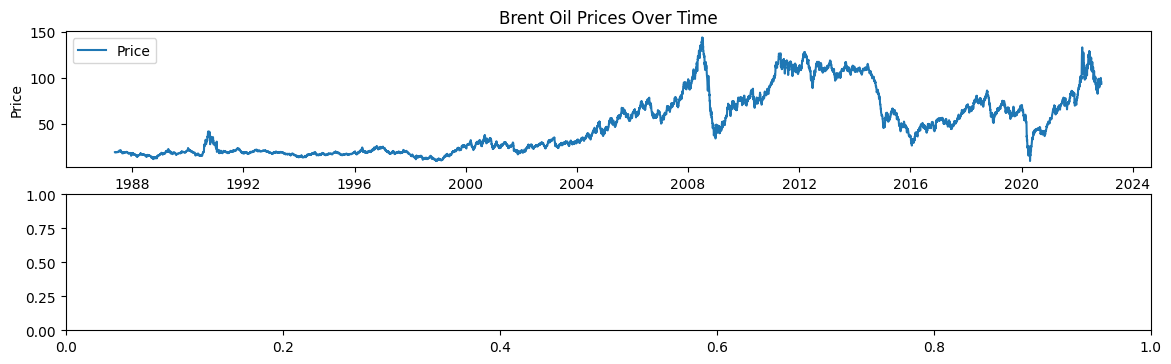

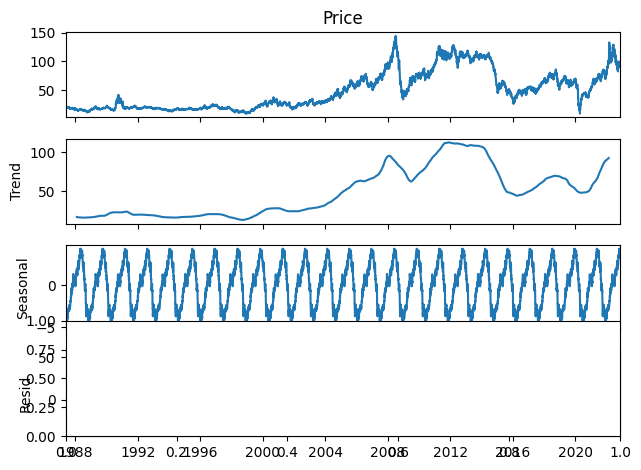

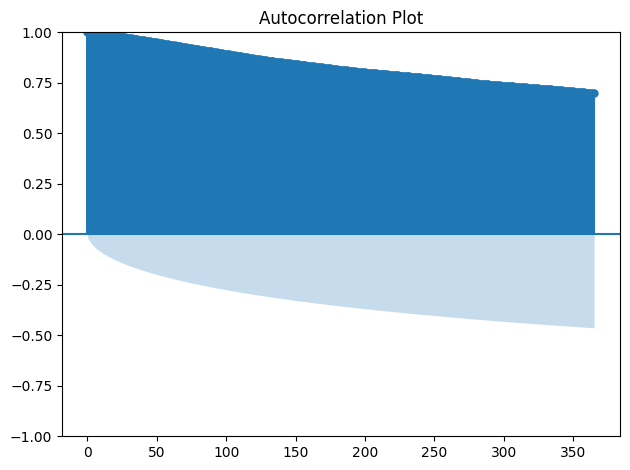

In [8]:
preprocessor.visualize_time_series(brent_oil_price_data)

### **Time Series Plot**
### Overall Trend:
- The plot shows a clear upward trend in Brent oil prices over the period depicted. This suggests that, generally, the price of oil has been increasing over time.

**Volatility:**

- The plot also shows significant fluctuations in oil prices, indicating a high degree of volatility. This is a characteristic feature of the oil market, which is influenced by various geopolitical and economic factors.
Specific Observations:
- There are periods of rapid price increases followed by periods of decline or stagnation. This pattern is likely due to factors such as global economic cycles, geopolitical events, and changes in supply and demand.
- Notable peaks and troughs can be observed, corresponding to specific events like the 2008 financial crisis, the COVID-19 pandemic, and geopolitical tensions in oil-producing regions.

**Potential Implications:**
- The upward trend in oil prices has implications for various sectors, including transportation, manufacturing, and energy production.
- The volatility in oil prices creates uncertainty for businesses and consumers, making it difficult to plan and budget.
- Policymakers and investors need to consider the impact of oil price fluctuations on economic growth, inflation, and energy security.

### **Seasonal Decomposition**
- Trend: This component captures the long-term direction of the time series. In this case, we see an overall upward trend in oil prices over the years.
- Seasonal: This component represents the periodic fluctuations in the data. With a period of 365, we can infer that there might be annual seasonality in oil prices. This could be due to factors like winter heating demand, summer driving season, or seasonal maintenance schedules in oil refineries.
- Residual: This component represents the noise or random fluctuations in the data that are not explained by the trend or seasonal components.

**Insights from the Decomposition:**

1.	Upward Trend: The upward trend in oil prices suggests increasing demand for oil, possibly due to economic growth in emerging markets and the increasing use of oil-based products.
2.	Annual Seasonality: The presence of annual seasonality indicates that oil prices tend to fluctuate in a predictable pattern each year. This could be influenced by factors like weather patterns, geopolitical events, and economic calendars.
3.	Residual Noise: The residual component shows that there is still significant variability in oil prices that is not captured by the trend and seasonal components. This suggests that other factors, such as unexpected geopolitical events or economic shocks, can have a significant impact on oil prices.

### **Autocorrelation**
The provided autocorrelation plot shows the autocorrelation function (ACF) for a time series. Here's how to interpret it:
- Lag: The horizontal axis represents the lag, or the number of time periods we are looking back.
- Autocorrelation Coefficient: The vertical axis shows the autocorrelation coefficient, which ranges from -1 to 1.
- Confidence Bands: The blue shaded area represents the 95% confidence interval. If an autocorrelation coefficient falls outside this band, it is statistically significant.

**Inferences from the Plot**
1.	High and Persistent Autocorrelation: The plot shows that the autocorrelation coefficients for most lags are very close to 1 and well above the confidence bands. This indicates a strong and persistent autocorrelation in the time series.
2.	Lack of Decay: The autocorrelation coefficients do not decay rapidly as the lag increases. This suggests that the influence of past values on future values is significant and long-lasting.



In [17]:
import pandas as pd
df=pd.read_csv("../Data/brent_oil_price_data.csv")